In [ ]:
# https://www.symphonyai.com/wp-content/uploads/2020/07/SAI-Topological-Data-Analysis-and-Machine-Learning-Better-Together-vf.pdf

In [1]:
import pandas as pd
import numpy as np

In [2]:
trainData = pd.read_csv('input/train.csv')
testData = pd.read_csv('input/test.csv')

len(trainData), len(testData)

(4659076, 2505190)

In [3]:
trainData.head(4)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543

homology_dimensions specifies the type of topological invariants to track:
- 0 for connected components 
- 1 for holes
- 2 for voids

while euclidean defines the metric we wish to apply in the persistent homology calculation.

In [4]:
import gtda.homology as hl

In [5]:
# represent data as a point cloud
point_cloud = np.array([[10,20],[15,30],[115,130]])[None, :, :]

# define topological features to track
homology_dimensions = [0, 1, 2]

# define simplicial complex to construct
persistence = hl.VietorisRipsPersistence(
    metric="euclidean", homology_dimensions=homology_dimensions
)

# calculate persistence diagram
persistence_diagram = persistence.fit_transform(point_cloud)

In [6]:
hl.VietorisRipsPersistence.plot(persistence_diagram, sample=0)

# Stock market crash analysis

In [10]:
import yfinance as yf

# data wrangling
import numpy as np
import pandas as pd

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
from ipynb.fs.full.plotting import plot_diagram, plot_point_cloud, plot_crash_detections, plot_crash_comparisons
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# tda magic
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.pipeline import Pipeline

### Load and explore S&P 500 time series

In [11]:
SP500 = yf.Ticker("^GSPC")
sp500_df = SP500.history(period="max")
sp500_df.head()

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000       0          0   
1928-01-03  17.760000  17.760000  17.760000  17.760000       0          0   
1928-01-04  17.719999  17.719999  17.719999  17.719999       0          0   
1928-01-05  17.549999  17.549999  17.549999  17.549999       0          0   
1928-01-06  17.660000  17.660000  17.660000  17.660000       0          0   

            Stock Splits  
Date                      
1927-12-30             0  
1928-01-03             0  
1928-01-04             0  
1928-01-05             0  
1928-01-06             0

### A simple baseline
Given that market crashes represent a sudden decline of stock prices, one simple approach to detect these changes involves tracking the first derivative of average price values over a rolling window. Indeed, in the figure below we can see that this naïve approach already captures the Black Monday crash (1987), the burst of the dot-com bubble (2000–2004), and the financial crisis (2007–2008).

![title](https://miro.medium.com/max/1250/1*8IR5j6uGXGlc0hXzQTgVTw.png)

By normalising this time series to take values in the [0,1] interval, we can apply a threshold to label points on our original time series where a crash occurred.

![title](https://miro.medium.com/max/1250/1*-14erHmpvY8c2z64qg-N8g.png)

#### Evidently this simple method is rather noisy.
With many points labelled as a crash, following this advice will result in over-panicking and selling your assets too soon. Let’s see if TDA can help us reduce the noise in the signal and obtain a more robust detector!

## The TDA pipeline

- Creating the Time Series
- Embedding the time series into a point cloud and constructing sliding windows of point clouds
- Building a filtration on each window to have an evolving structure encoding the geometrical shape of each window
- Extracting the relevant features of those windows using persistence homology
- Comparing each window by measuring the difference of those features from one window to the next
- Constructing an indicator of crash based on this difference.

![title](https://miro.medium.com/max/875/1*6BXXsSdSqPzPOSLeVEzi3w.jpeg)

### Time series as point clouds — Takens’ embedding

A typical starting point in a TDA pipeline is to generate a simplicial complex from a point cloud. Thus, the crucial question in time series applications is how to generate such point clouds? Discrete time series, like the ones we are considering, are typically visualised as scatter plots in two dimensions. This representation makes the local behaviour of the time series easy to track by scanning the plot from left to right. But it is often ineffective at conveying important effects which may be occurring over larger time scales.
<br><br>
One well-known set of techniques for capturing periodic behaviour comes from Fourier analysis. For instance, the discrete Fourier transform of a temporal window over the time series gives information on whether the signal in that window arises as the sum of a few simple periodic signals.
<br><br>
For our purposes we consider a different way of encoding a time-evolving process. It is based on the idea that some key properties of the dynamics can be unveiled effectively in higher dimensions. We begin by illustrating a way of representing a univariate time series as a point cloud, i.e. a set of vectors in a Euclidean space of arbitrary dimension.
The procedure works as follows: we pick two integers d and τ. For each time tᵢ ∈ (t₀, t₁, …), we collect the values of the variable y at d distinct times, evenly spaced by τ and starting at tᵢ, and present them as a vector with d entries, namely:
<br><br>
![title](https://miro.medium.com/max/481/1*FYKcsZv775go9kqkTrdisA.png)
<br><br>
The result is a set of vectors in d-dimensional space! τ is called the time delay parameter, and d the embedding dimension.
This time-delay embedding technique is also called Takens’ embedding after Floris Takens, who demonstrated its significance with a celebrated theorem in the context of nonlinear dynamical systems.
<br><br>
Finally, applying this procedure separately on sliding windows over the full time series leads to a time series of point clouds (one per sliding window) with possibly interesting topologies. The GIF below shows how such a point cloud is generated in 2-dimensions.
<br><br>
![title](https://miro.medium.com/max/1250/1*_Xz--AkZjbjEcHV_Sc9MXg.gif)

### From point clouds to persistence diagrams

Now that we know how to generate a time series of point clouds, what can we do with this information? Enter persistent homology, which looks for topological features in a simplicial complex that persist over some range of parameter values. Typically, a feature, such as a hole, will initially not be observed, then will appear, and after a range of values of the parameter will disappear again.
<br><br>
![title](https://miro.medium.com/max/875/1*BaaTP81riE9GXJdBFeQ_Bg.png)
![title](https://miro.medium.com/max/875/1*_xCuCWAnzA5NiQ0SDd5p8g.png)

### Distances between persistent diagrams

Given two windows and their corresponding persistence diagrams, we can calculate a variety of distance metrics. Here we compare two distances, one based on the notion of a persistence landscape, the other on Betti curves.
<br><br>
![title](https://miro.medium.com/max/1250/1*AyOy6mQOcdc96NJ-3vDpQw.png)

From these figures we can infer that the metric based on landscape distance is less noisy than the Betti curves.

### A topological indicator
Using the landscape distance between windows as our topological feature, it is a simple matter to normalise it as we did for the baseline model. Below we show the resulting detection of stock market crashes for the dot-com bubble and global financial crisis. Compared to our simple baseline, we can see that using topological features appears to reduce the noise in the signal of interest.
![title](https://miro.medium.com/max/1250/1*xj7DDJ-QB_gWOy0X7e8Q6A.png)
![title](https://miro.medium.com/max/1250/1*Ll_1xeDDEcoSgiu88zydbw.png)

# Code

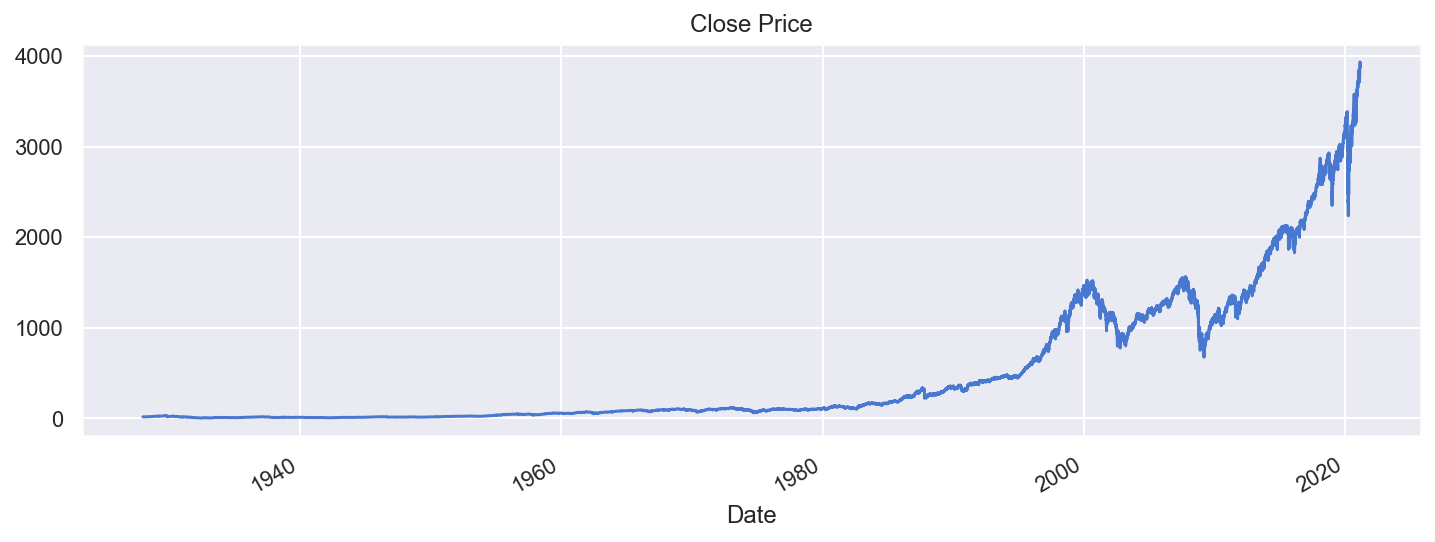

In [12]:
price_df = sp500_df['Close']
price_df.plot()
plt.title('Close Price')
plt.show()

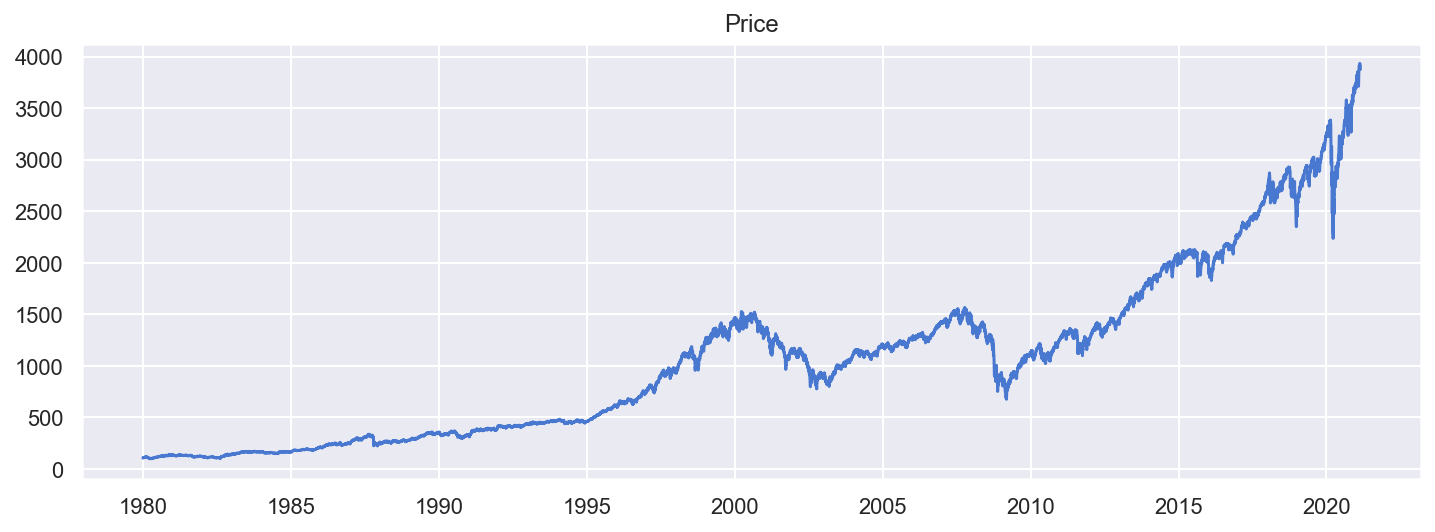

In [13]:
start_year = '1980'
# use pad to replace missing values by last non-missing value
price_resampled_df = price_df.resample('24H').pad()[start_year:]

plt.plot(price_resampled_df)
plt.title('Price')
plt.show()

### Time series as point clouds -- Takens' embedding

In [14]:
embedding_dimension = 3
embedding_time_delay = 2

In [15]:
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

price_values = price_resampled_df.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

In [16]:
window_width = 30
window_stride = 4

In [17]:
sliding_window = ts.SlidingWindow(size=window_width, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

In [18]:
window_num = 20
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

### A simple baseline
Here we create a simple baseline that tracks the first derivative of our time series over a sliding window. By using the SlidingWindow class from giotto-learn we can quickly obtain arrays that are amenable for the scikit-learn APIs:

In [19]:
window_width_price = window_width + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(size=window_width_price, stride=window_stride)
window_indices = sliding_window_price.slice_windows(price_values)
price_windows = sliding_window_price.fit_transform(price_values)

In [20]:
abs_derivative_of_means = np.abs(np.mean(np.diff(price_windows, axis=0), axis=1))

In [21]:
# define time index to combine with numpy arrays
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = price_resampled_df.iloc[indices].index

In [22]:
resampled_close_price_derivs = price_resampled_df.loc[time_index_derivs]

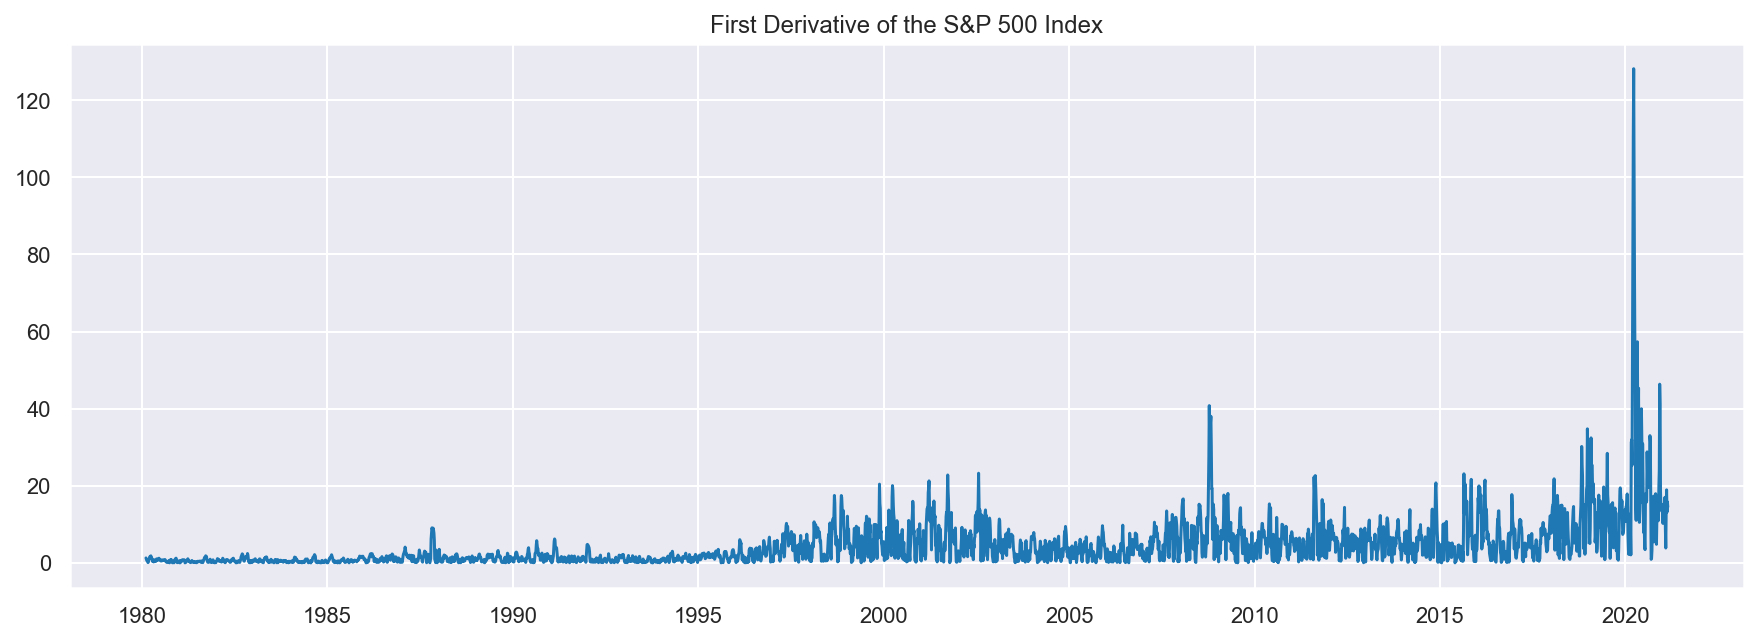

In [23]:
plt.figure(figsize=(15,5))
plt.plot(time_index_derivs, abs_derivative_of_means, color='#1f77b4')
plt.title('First Derivative of the S&P 500 Index')
plt.savefig('./images/metric_first_derivative.png')
plt.show()

### Persistence diagrams

In [24]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=1)
diagrams = VR.fit_transform(price_embedded_windows)

In [25]:
plot_diagram(diagrams[window_num])

### Homological derivatives

In [26]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils import check_diagrams,validate_params #,validate_metric_params

In [27]:
class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):
        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])
        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = (
                np.concatenate(Xt).reshape(len(self.homology_dimensions_), len(X) - 1).T
            )
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

### Landscape distances

In [28]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=1,
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

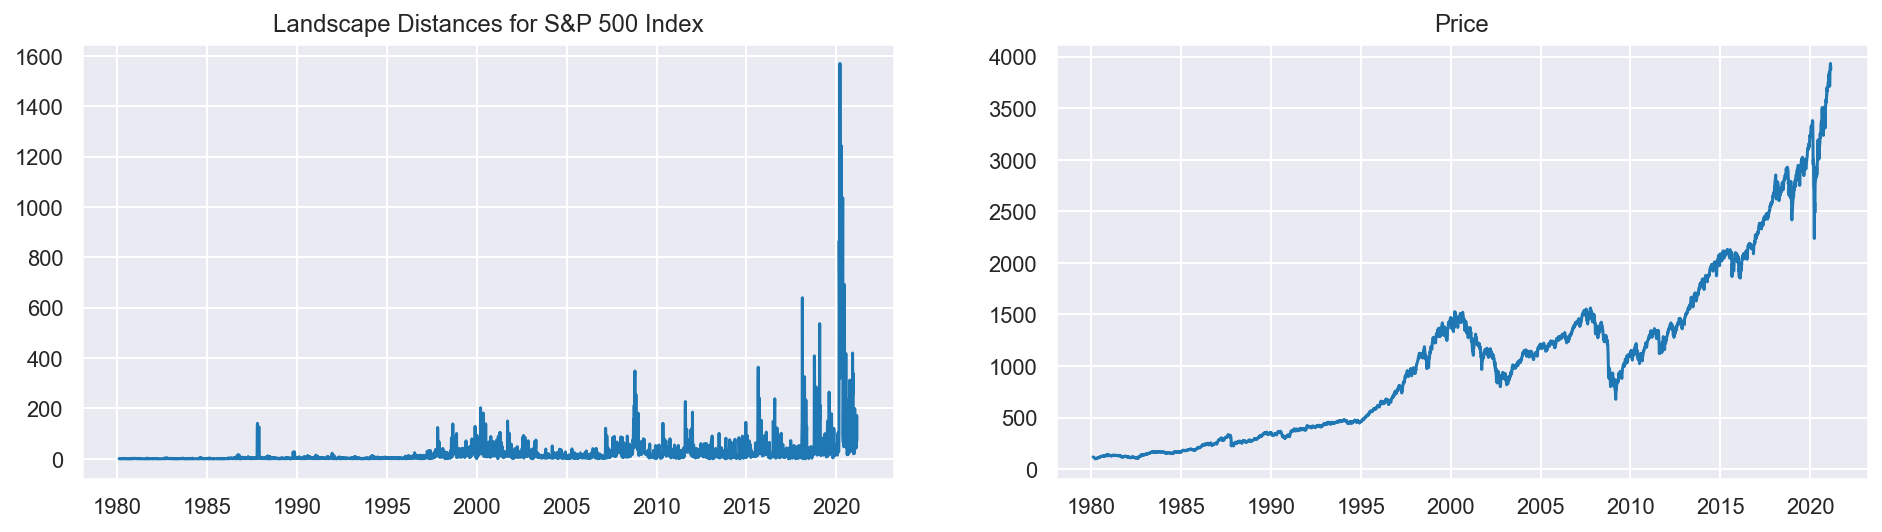

In [29]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs, "#1f77b4")
plt.title("Price")
plt.show()

In [30]:
len(diagrams), len(landscape_succ_dists)

(3749, 3748)

### Distances among diagrams using Betti curves

In [31]:
metric_params2 = {"p": 2, "n_bins": 1000}

bettiHomDer = HomologicalDerivative(metric='betti',
                                    metric_params=metric_params2,
                                    order=2, n_jobs=1)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

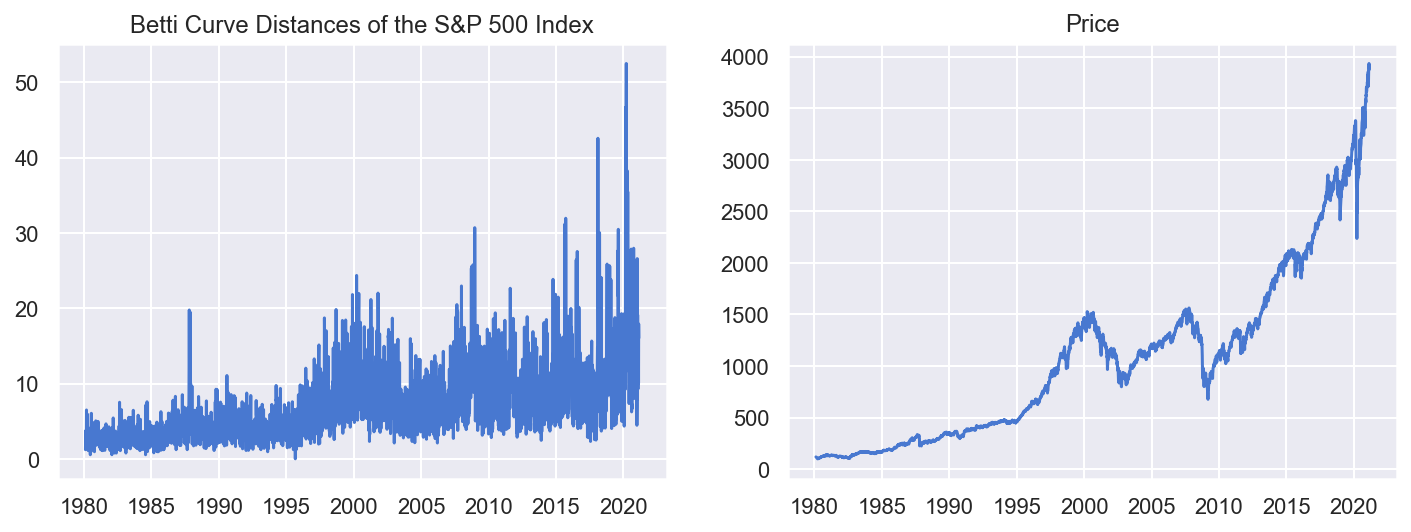

In [32]:
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Betti Curve Distances of the S&P 500 Index')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

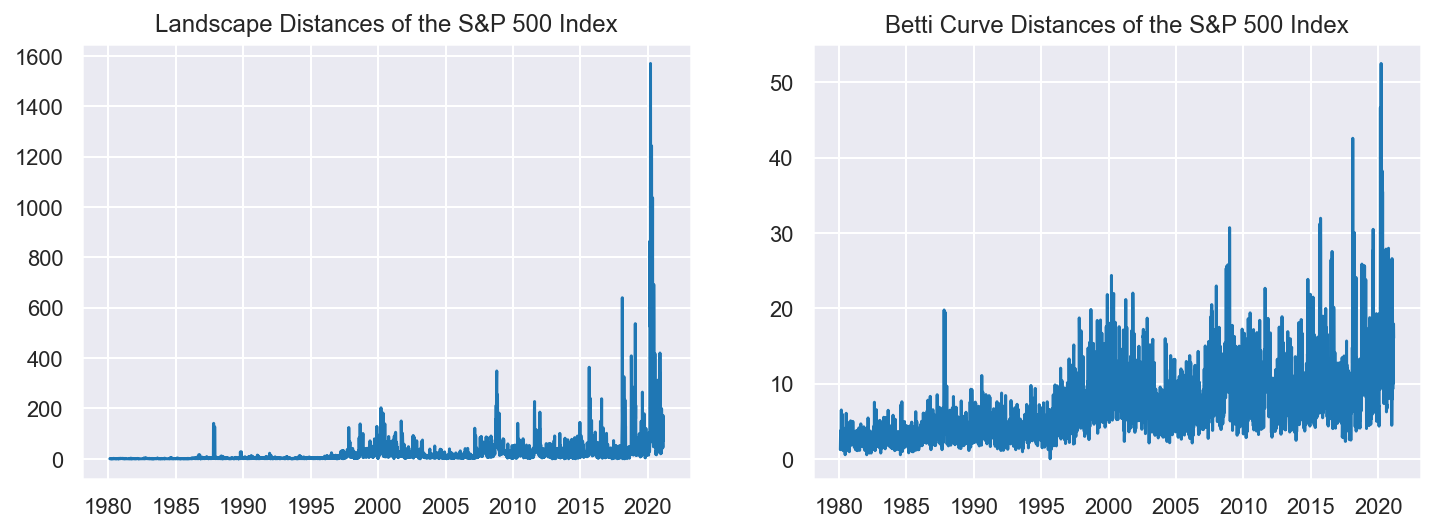

In [33]:
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of the S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the S&P 500 Index')
plt.savefig('./images/metric_landscape_betti.png')
plt.show()

### Topological indicators for crashes

Let's investigate the last two major market crashes:

- dot-com crash: from March 11, 2000, to October 9, 2004
- Subprime mortgage crisis: from December 2007 – June 2009

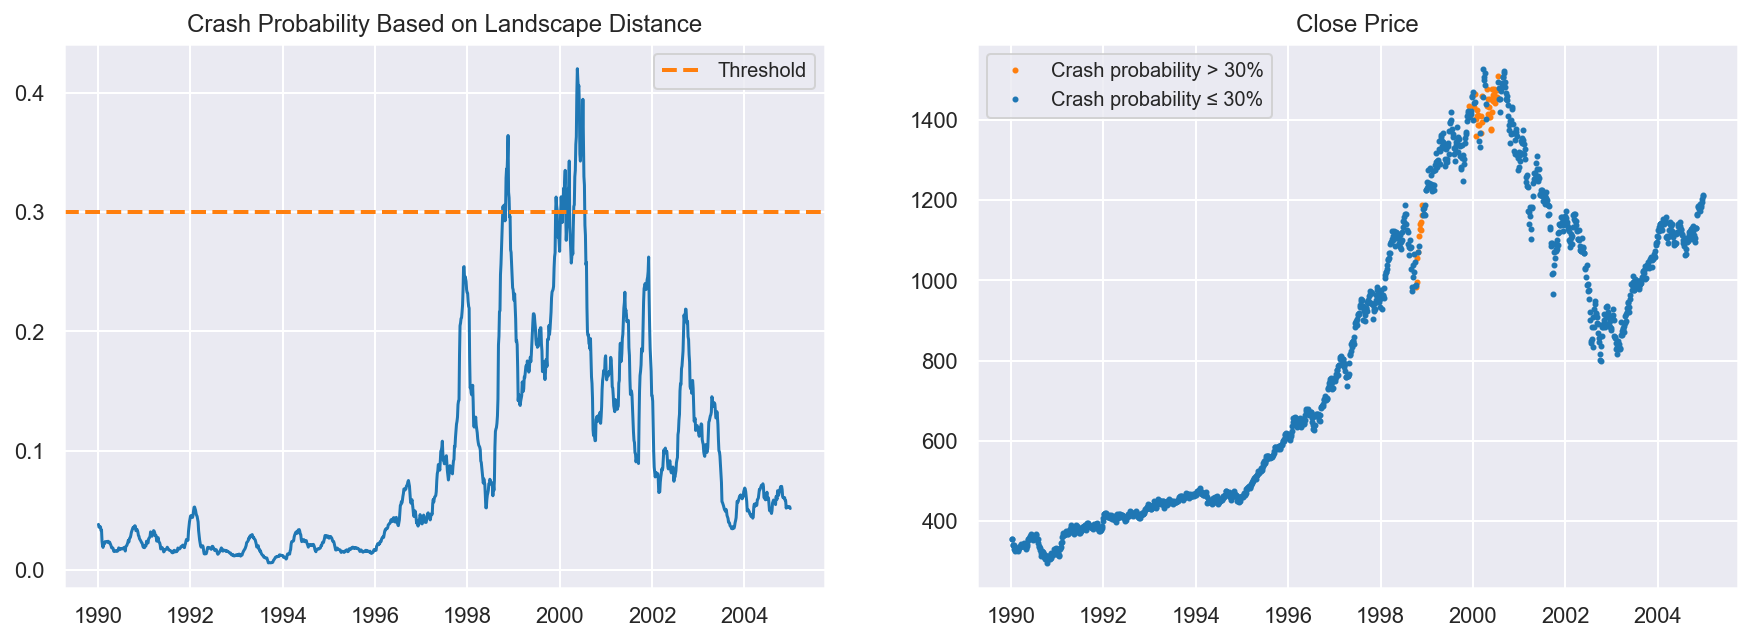

In [34]:
plot_crash_detections(
    start_date="1990-01-01",
    end_date="2005-01-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

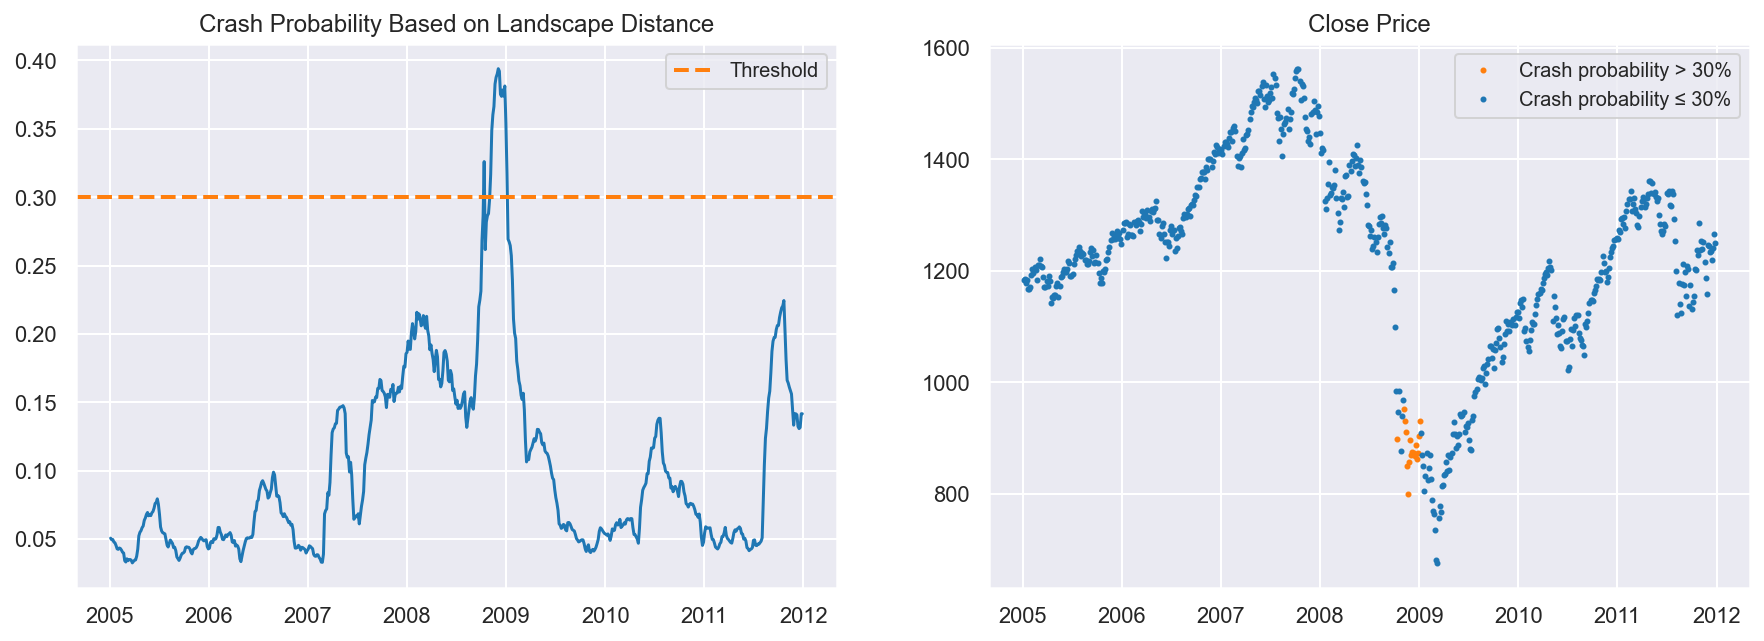

In [35]:
plot_crash_detections(
    start_date="2005-01-01",
    end_date="2012-01-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

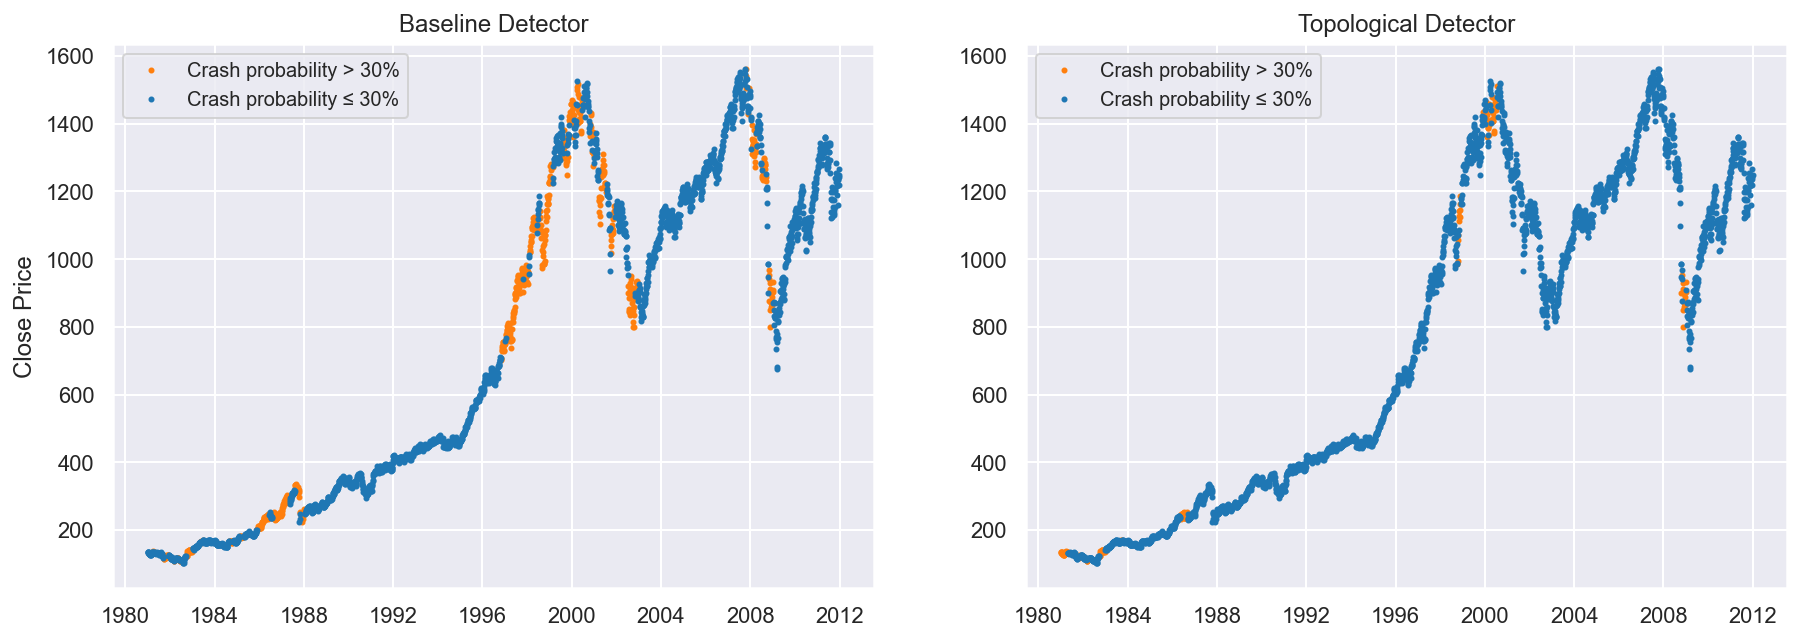

In [36]:
plot_crash_comparisons(
    start_date="1981-01-01",
    end_date="2012-01-01",
    threshold=0.3,
    distances_1=abs_derivative_of_means,
    distances_2=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
)

## ToMATo
Topological Mode Analysis Tool

![title](https://miro.medium.com/max/1250/1*qT3T4M5swQZ3i1GgE3eorg.png)

In [37]:
from ipynb.fs.full.clusters import *

[###] Visual packages could not be imported ...


usetex mode requires TeX.


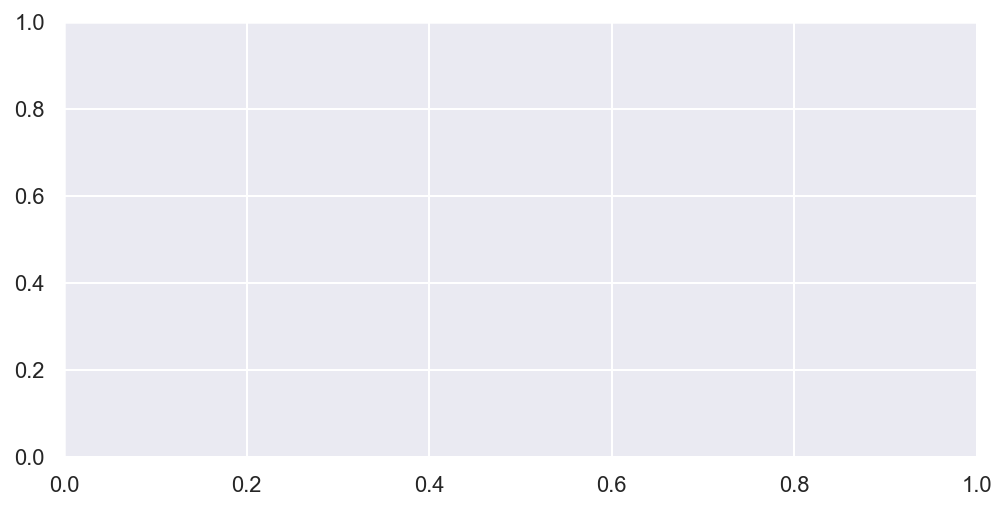

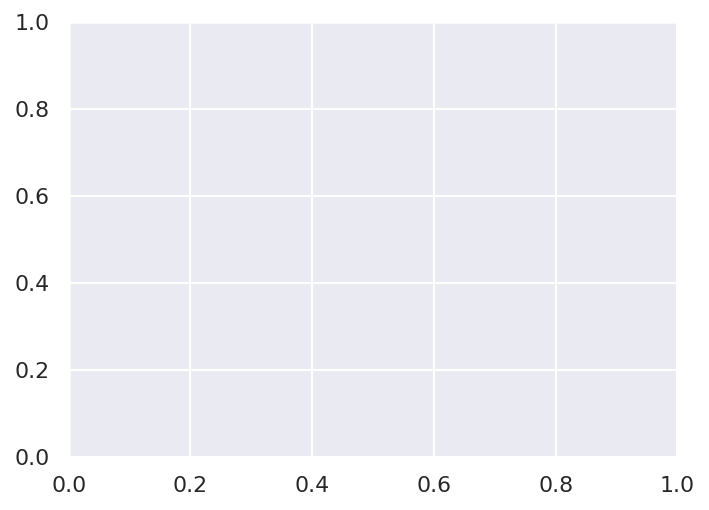

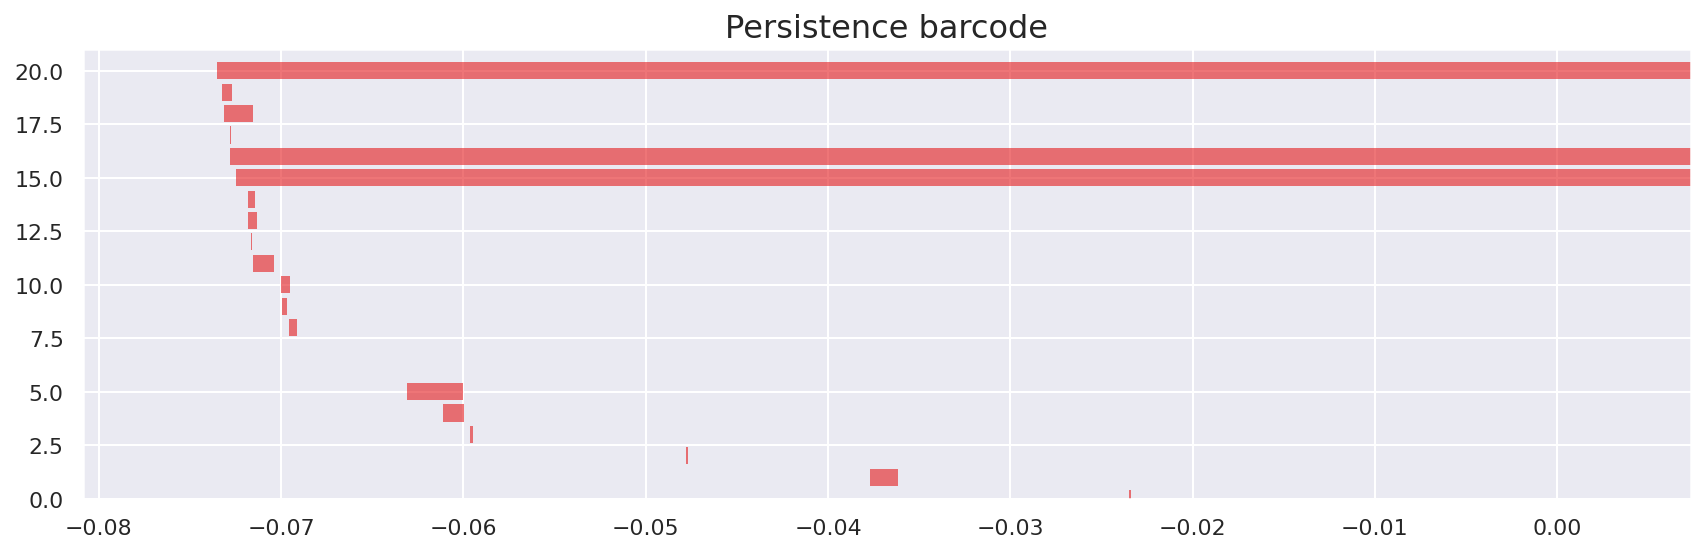

In [38]:
gen = ClusterGenerator(structure='anisotropy', randomize=45)
clf = ToMaTo(*gen.generate())
clf.estimate_clusters(graph=True)

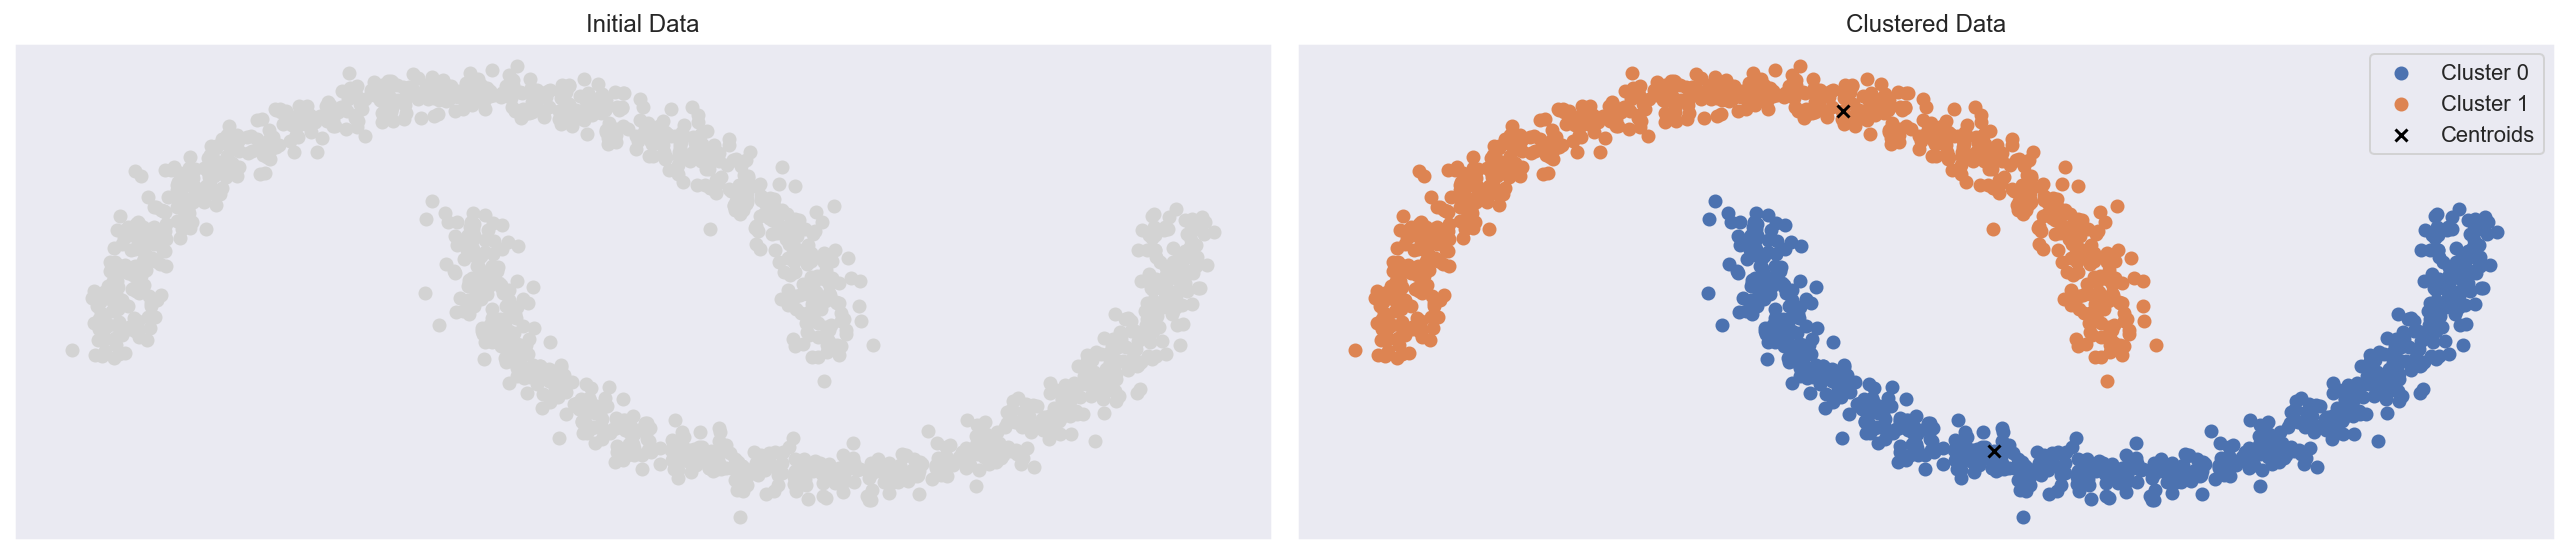

In [63]:
gen = ClusterGenerator(structure='moons', randomize=45)
clf = ToMaTo(*gen.generate())
_ = clf.estimate_density(graph=False)
clf.estimate_clusters(graph=False)
prd_1 = clf.fit_predict(num_clusters=2, graph=True)

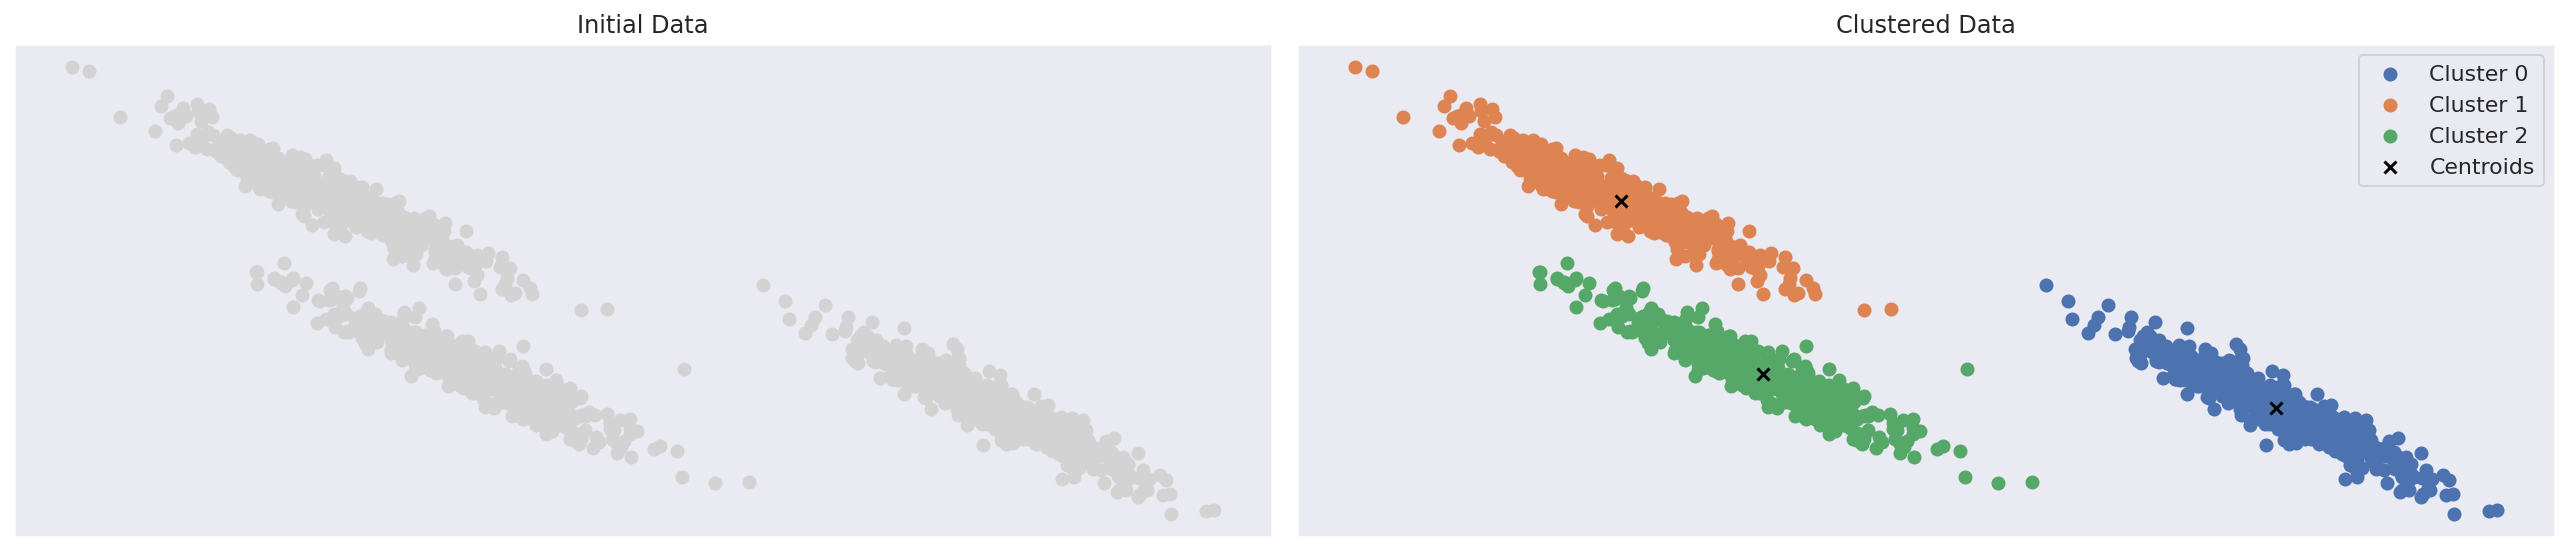

In [71]:
gen = ClusterGenerator(structure='anisotropy', randomize=45)
clf = ToMaTo(*gen.generate())
_ = clf.estimate_density(graph=False)
clf.estimate_clusters(graph=False)
prd_2 = clf.fit_predict(num_clusters=3, graph=True)

In [66]:
set(prd_2[0])

{0, 23, 45}

In [69]:
prd_1

(array([0, 1, 0, ..., 1, 0, 1]),
 array([0.68297876, 0.25688786]),
 array([-0.40139618,  0.92435161]))